# Univariate analysis NDVI

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import warnings
from pygam import LinearGAM, s, l
from sklearn import linear_model, metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from PIL import Image as im

In [2]:
#! pip install pygam

## 1. Modeling vegetation densities for buffer distances of 100 meters

In [3]:
# load greenspace metrics at 100m geodataframe
gdf_100 = gpd.read_file("thesis_project/output/dataframes/greenspace_metrics_100_df_2.json")
gdf_100.head()

,NDVI_100,Greenspace%_100,Canopy%_100,Grass%_100,Shrubs%_100,geometry
0,0.455823,0.992861,2.168372e-17,0.006803,0.848073,POINT (386483.262 417703.544)
1,0.387782,0.521713,2.176871e-01,0.097506,0.190476,POINT (395310.475 388609.235)
2,0.389722,0.979774,5.117090e-17,0.083900,0.891156,POINT (384225.708 417867.819)
3,0.623486,0.771565,8.163265e-02,0.083900,0.612245,POINT (390673.998 416261.747)
4,0.628733,0.886972,6.643991e-01,0.052154,0.163265,POINT (393523.154 393041.484)


### 1.1. Model 1: greenspace ~ linear(NDVI)

In [4]:
# data/predictors as the NDVI_100
df_100 = pd.DataFrame(gdf_100, columns=['NDVI_100'])

# target as Greenspace%_100
target_100 = pd.DataFrame(gdf_100, columns=['Greenspace%_100'])

# define X and Y
X = df_100
y = target_100['Greenspace%_100']

# split independent and dependent variables into training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [5]:
# Model 1
warnings.filterwarnings("ignore", category=RuntimeWarning)
uni_gam_100_1 = LinearGAM(l(0)).fit(X_train, y_train)

uni_gam_100_1.gridsearch(X_train, y_train)
uni_gam_100_1.summary()

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      1.9999
Link Function:                     IdentityLink Log Likelihood:                                -84351.7622
Number of Samples:                         4749 AIC:                                           168709.5242
                                                AICc:                                          168709.5293
                                                GCV:                                                0.0243
                                                Scale:                                              0.0243
                                                Pseudo R-Squared:                                   0.6833
Feature Function                  Lam

/var/folders/6g/kgz5rml118s6lqw25w5sv5mr0000gn/T/ipykernel_1007/161998086.py:6: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  uni_gam_100_1.summary()


### 1.2. Model 2: greenspace ~ spline(NDVI)

In [6]:
# Model 2
warnings.filterwarnings("ignore", category=RuntimeWarning)
uni_gam_100_2 = LinearGAM(s(0)).fit(X_train, y_train)

uni_gam_100_2.gridsearch(X_train, y_train)
uni_gam_100_2.summary()

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     10.1105
Link Function:                     IdentityLink Log Likelihood:                                -93747.8378
Number of Samples:                         4749 AIC:                                           187517.8966
                                                AICc:                                          187517.9534
                                                GCV:                                                0.0221
                                                Scale:                                               0.022
                                                Pseudo R-Squared:                                   0.7134
Feature Function                  Lam

/var/folders/6g/kgz5rml118s6lqw25w5sv5mr0000gn/T/ipykernel_1007/2437069232.py:6: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  uni_gam_100_2.summary()


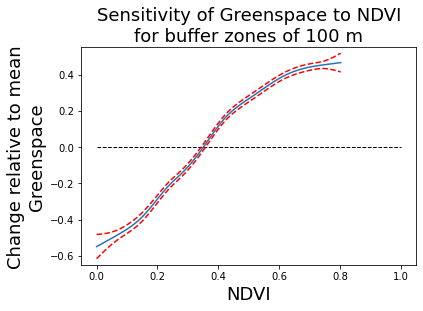

In [97]:
# plotting best greenspace_100 model
for i, term in enumerate(uni_gam_100_2.terms):
    if term.isintercept:
        continue

    XX = uni_gam_100_2.generate_X_grid(term=i)
    pdep, confi = uni_gam_100_2.partial_dependence(term=i, X=XX, width=0.95)

    plt.figure()
    plt.plot(XX[:, term.feature], pdep)
    plt.hlines(y=0, xmin=0, xmax=1, linewidth=1, color='black', linestyle='--')
    plt.plot(XX[:, term.feature], confi, c='r', ls='--')
    ax = plt.gca()
    ax.set_ylim([-0.65, 0.55])
    # set title, xlabel and ylabel
    plt.title('Sensitivity of Greenspace to NDVI\nfor buffer zones of 100 m', fontsize=18)
    plt.xlabel('NDVI', fontsize=18)
    plt.ylabel('Change relative to mean\nGreenspace', fontsize=18)
    # save the figure
    plt.savefig('thesis_project/visualizations/modelling/univariate/gam_greenspace_100_best_plot_2.png', dpi=300, bbox_inches='tight')
    im.open('thesis_project/visualizations/modelling/univariate/gam_greenspace_100_best_plot_2.png').save('thesis_project/visualizations/modelling/univariate/gam_greenspace_100_best_plot_2.bmp')
    plt.show()

In [121]:
# Change in low NDVI values: how does Greenspace% increase, if NDVI changes from 0.25 to 0.35?
green_l0 = uni_gam_100_2.predict(0.20)
green_l1 = uni_gam_100_2.predict(0.30)
green_sens_low = float(green_l1 - green_l0)
print('If NDVI goes from 0.25 to 0.35, Greenspace%_100 increases by:', green_sens_low)

If NDVI goes from 0.25 to 0.35, Greenspace%_100 increases by: 0.17756113980713956


In [122]:
# Change in mid NDVI values: how does Greenspace% increase, if NDVI changes from 0.45 to 0.55?
green_m0 = uni_gam_100_2.predict(0.40)
green_m1 = uni_gam_100_2.predict(0.50)
green_sens_mid = float(green_m1 - green_m0)
print('If NDVI goes from 0.45 to 0.55, Greenspace%_100 increases by:', green_sens_mid)

If NDVI goes from 0.45 to 0.55, Greenspace%_100 increases by: 0.15092372111359387


In [123]:
# Change in high NDVI values: how does Greenspace% increase, if NDVI changes from 0.65 to 0.75?
green_h0 = uni_gam_100_2.predict(0.60)
green_h1 = uni_gam_100_2.predict(0.70)
green_sens_hig = float(green_h1 - green_h0)
print('If NDVI goes from 0.65 to 0.75, Greenspace%_100 increases by:', green_sens_hig)

If NDVI goes from 0.65 to 0.75, Greenspace%_100 increases by: 0.062488191175932406


### 1.3. Model 3: tree canopy ~ linear(NDVI)

In [11]:
# NDVI_100 as the predictor
df = pd.DataFrame(gdf_100, columns=['NDVI_100'])

# Canopy%_100 as the target
target = pd.DataFrame(gdf_100, columns=['Canopy%_100'])

# define X and y
X = df
y = target['Canopy%_100']

# split independent and dependent variables into training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# fit the linear model
lm_100 = linear_model.LinearRegression()
model_100 = lm_100.fit(X_train,y_train)

In [12]:
# Model 3
warnings.filterwarnings("ignore", category=RuntimeWarning)
uni_gam_100_3 = LinearGAM(l(0)).fit(X_train, y_train)

uni_gam_100_3.gridsearch(X_train, y_train)
uni_gam_100_3.summary()

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      1.9948
Link Function:                     IdentityLink Log Likelihood:                                -66029.3274
Number of Samples:                         4749 AIC:                                           132064.6444
                                                AICc:                                          132064.6495
                                                GCV:                                                0.0303
                                                Scale:                                              0.0303
                                                Pseudo R-Squared:                                   0.0508
Feature Function                  Lam

/var/folders/6g/kgz5rml118s6lqw25w5sv5mr0000gn/T/ipykernel_1007/2799447770.py:6: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  uni_gam_100_3.summary()


### 1.4. Model 4: tree canopy ~ spline(NDVI)

In [13]:
# Model 4
warnings.filterwarnings("ignore", category=RuntimeWarning)
uni_gam_100_4 = LinearGAM(s(0)).fit(X_train, y_train)

uni_gam_100_4.gridsearch(X_train, y_train)
uni_gam_100_4.summary()

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     12.6008
Link Function:                     IdentityLink Log Likelihood:                                -69592.9031
Number of Samples:                         4749 AIC:                                           139213.0076
                                                AICc:                                          139213.0915
                                                GCV:                                                 0.029
                                                Scale:                                              0.0289
                                                Pseudo R-Squared:                                   0.0988
Feature Function                  Lam

/var/folders/6g/kgz5rml118s6lqw25w5sv5mr0000gn/T/ipykernel_1007/3283584014.py:6: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  uni_gam_100_4.summary()


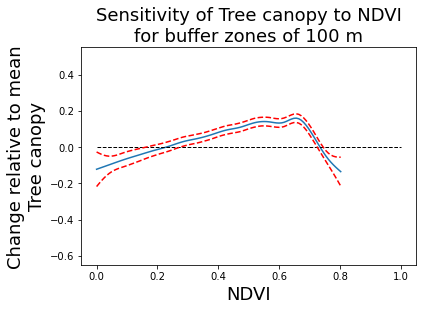

In [98]:
# plotting best canopy_100 model
for i, term in enumerate(uni_gam_100_4.terms):
    if term.isintercept:
        continue

    XX = uni_gam_100_4.generate_X_grid(term=i)
    pdep, confi = uni_gam_100_4.partial_dependence(term=i, X=XX, width=0.95)

    plt.figure()
    plt.plot(XX[:, term.feature], pdep)
    plt.hlines(y=0, xmin=0, xmax=1, linewidth=1, color='black', linestyle='--')
    plt.plot(XX[:, term.feature], confi, c='r', ls='--')
    ax = plt.gca()
    ax.set_ylim([-0.65, 0.55])
    # set title, xlabel and ylabel
    plt.title('Sensitivity of Tree canopy to NDVI\nfor buffer zones of 100 m', fontsize=18)
    plt.xlabel('NDVI', fontsize=18)
    plt.ylabel('Change relative to mean\nTree canopy', fontsize=18)
    # save the figure
    plt.savefig('thesis_project/visualizations/modelling/univariate/gam_canopy_100_best_plot_2.png', dpi=300, bbox_inches='tight')
    im.open('thesis_project/visualizations/modelling/univariate/gam_canopy_100_best_plot_2.png').save('thesis_project/visualizations/modelling/univariate/gam_canopy_100_best_plot_2.bmp')
    plt.show()

In [124]:
# Change in low NDVI values: how does canopy% increase, if NDVI changes from 0.25 to 0.35?
canopy_l0 = uni_gam_100_4.predict(0.20)
canopy_l1 = uni_gam_100_4.predict(0.30)
canopy_sens_low = float(canopy_l1 - canopy_l0)
print('If NDVI goes from 0.25 to 0.35, Canopy%_100 increases by:', canopy_sens_low)

If NDVI goes from 0.25 to 0.35, Canopy%_100 increases by: 0.0497382459229099


In [125]:
# Change in mid NDVI values: how does canopy% increase, if NDVI changes from 0.45 to 0.55?
canopy_m0 = uni_gam_100_4.predict(0.40)
canopy_m1 = uni_gam_100_4.predict(0.50)
canopy_sens_mid = float(canopy_m1 - canopy_m0)
print('If NDVI goes from 0.45 to 0.55, Canopy%_100 increases by:', canopy_sens_mid)

If NDVI goes from 0.45 to 0.55, Canopy%_100 increases by: 0.0437499395868525


In [126]:
# Change in high NDVI values: how does canopy% increase, if NDVI changes from 0.65 to 0.75?
canopy_h0 = uni_gam_100_4.predict(0.60)
canopy_h1 = uni_gam_100_4.predict(0.70)
canopy_sens_hig = float(canopy_h1 - canopy_h0)
print('If NDVI goes from 0.65 to 0.75, Canopy%_100 increases by:', canopy_sens_hig)

If NDVI goes from 0.65 to 0.75, Canopy%_100 increases by: -0.03925067938015117


### 1.5. Model 5: forbs and shrubs ~ linear(NDVI)

In [18]:
# data/predictors as the NDVI_100
df_100 = pd.DataFrame(gdf_100, columns=['NDVI_100'])

# target as Shrubs%_100
target_100 = pd.DataFrame(gdf_100, columns=['Shrubs%_100'])

# define X and y
X = df_100
y = target_100['Shrubs%_100']

# split independent and dependent variables into training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# fit the linear model
lm_100 = linear_model.LinearRegression()
model_100 = lm_100.fit(X_train,y_train)

In [19]:
# Model 5
warnings.filterwarnings("ignore", category=RuntimeWarning)
uni_gam_100_5 = LinearGAM(l(0)).fit(X_train, y_train)

uni_gam_100_5.gridsearch(X_train, y_train)
uni_gam_100_5.summary()

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      1.9978
Link Function:                     IdentityLink Log Likelihood:                                -26872.0266
Number of Samples:                         4749 AIC:                                            53750.0489
                                                AICc:                                           53750.0539
                                                GCV:                                                0.0672
                                                Scale:                                              0.0672
                                                Pseudo R-Squared:                                   0.1617
Feature Function                  Lam

/var/folders/6g/kgz5rml118s6lqw25w5sv5mr0000gn/T/ipykernel_1007/2907954286.py:6: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  uni_gam_100_5.summary()


### 1.6. Model 6: forbs and shrubs ~ spline(NDVI)

In [20]:
# Model 6
warnings.filterwarnings("ignore", category=RuntimeWarning)
uni_gam_100_6 = LinearGAM(s(0)).fit(X_train, y_train)

uni_gam_100_6.gridsearch(X_train, y_train)
uni_gam_100_6.summary()

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      4.6163
Link Function:                     IdentityLink Log Likelihood:                                -27514.9148
Number of Samples:                         4749 AIC:                                            55041.0622
                                                AICc:                                           55041.0779
                                                GCV:                                                0.0659
                                                Scale:                                              0.0658
                                                Pseudo R-Squared:                                   0.1799
Feature Function                  Lam

/var/folders/6g/kgz5rml118s6lqw25w5sv5mr0000gn/T/ipykernel_1007/201407906.py:6: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  uni_gam_100_6.summary()


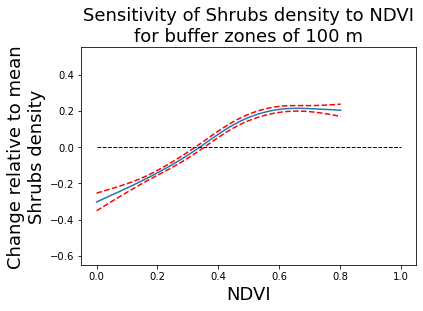

In [99]:
# plotting best model
for i, term in enumerate(uni_gam_100_6.terms):
    if term.isintercept:
        continue

    XX = uni_gam_100_6.generate_X_grid(term=i)
    pdep, confi = uni_gam_100_6.partial_dependence(term=i, X=XX, width=0.95)

    plt.figure()
    plt.plot(XX[:, term.feature], pdep)
    plt.hlines(y=0, xmin=0, xmax=1, linewidth=1, color='black', linestyle='--')
    plt.plot(XX[:, term.feature], confi, c='r', ls='--')
    ax = plt.gca()
    ax.set_ylim([-0.65, 0.55])
    # set title, xlabel and ylabel
    plt.title('Sensitivity of Shrubs density to NDVI\nfor buffer zones of 100 m', fontsize=18)
    plt.xlabel('NDVI', fontsize=18)
    plt.ylabel('Change relative to mean\nShrubs density', fontsize=18)    
    # save the figure
    plt.savefig('thesis_project/visualizations/modelling/univariate/gam_shrubs_100_best_plot_2.png', dpi=300, bbox_inches='tight')
    im.open('thesis_project/visualizations/modelling/univariate/gam_shrubs_100_best_plot_2.png').save('thesis_project/visualizations/modelling/univariate/gam_shrubs_100_best_plot_2.bmp')
    plt.show()

In [127]:
# Change in low NDVI values: how does Shrubs% increase, if NDVI changes from 0.25 to 0.35?
shrubs_l0 = uni_gam_100_6.predict(0.20)
shrubs_l1 = uni_gam_100_6.predict(0.30)
shrubs_sens_low = float(shrubs_l1 - shrubs_l0)
print('If NDVI goes from 0.25 to 0.35, Shrubs%_100 increases by:', shrubs_sens_low)

If NDVI goes from 0.25 to 0.35, Shrubs%_100 increases by: 0.09777238149995937


In [129]:
# Change in mid NDVI values: how does Shrubs% increase, if NDVI changes from 0.45 to 0.55?
shrubs_m0 = uni_gam_100_6.predict(0.40)
shrubs_m1 = uni_gam_100_6.predict(0.50)
shrubs_sens_mid = float(shrubs_m1 - shrubs_m0)
print('If NDVI goes from 0.45 to 0.55, Shrubs%_100 increases by:', shrubs_sens_mid)

If NDVI goes from 0.45 to 0.55, Shrubs%_100 increases by: 0.09264013365186013


In [130]:
# Change in high NDVI values: how does Shrubs% increase, if NDVI changes from 0.65 to 0.75?
shrubs_h0 = uni_gam_100_6.predict(0.60)
shrubs_h1 = uni_gam_100_6.predict(0.70)
shrubs_sens_hig = float(shrubs_h1 - shrubs_h0)
print('If NDVI goes from 0.65 to 0.75, Shrubs%_100 increases by:', shrubs_sens_hig)

If NDVI goes from 0.65 to 0.75, Shrubs%_100 increases by: 0.004204302974184393


### 1.7. Model 7: grass ~ linear(NDVI)

In [25]:
# NDVI_100 as the predictor
df = pd.DataFrame(gdf_100, columns=['NDVI_100'])

# Grass%_100 as the target
target = pd.DataFrame(gdf_100, columns=['Grass%_100'])

# define X and y
X = df
y = target['Grass%_100']

# split independent and dependent variables into training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# fit the linear model
lm_100 = linear_model.LinearRegression()
model_100 = lm_100.fit(X_train,y_train)

In [26]:
# Model 7
warnings.filterwarnings("ignore", category=RuntimeWarning)
uni_gam_100_7 = LinearGAM(l(0)).fit(X_train, y_train)

uni_gam_100_7.gridsearch(X_train, y_train)
uni_gam_100_7.summary()

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      1.9978
Link Function:                     IdentityLink Log Likelihood:                                -81601.5616
Number of Samples:                         4749 AIC:                                           163209.1189
                                                AICc:                                          163209.1239
                                                GCV:                                                0.0251
                                                Scale:                                              0.0251
                                                Pseudo R-Squared:                                   0.1734
Feature Function                  Lam

/var/folders/6g/kgz5rml118s6lqw25w5sv5mr0000gn/T/ipykernel_1007/822825484.py:6: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  uni_gam_100_7.summary()


### 1.8. Model 8: grass ~ spline(NDVI)

In [27]:
# Model 8
warnings.filterwarnings("ignore", category=RuntimeWarning)
uni_gam_100_8 = LinearGAM(s(0)).fit(X_train, y_train)

uni_gam_100_8.gridsearch(X_train, y_train)
uni_gam_100_8.summary()

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     10.1105
Link Function:                     IdentityLink Log Likelihood:                                -85312.1923
Number of Samples:                         4749 AIC:                                           170646.6055
                                                AICc:                                          170646.6623
                                                GCV:                                                0.0241
                                                Scale:                                               0.024
                                                Pseudo R-Squared:                                   0.2089
Feature Function                  Lam

/var/folders/6g/kgz5rml118s6lqw25w5sv5mr0000gn/T/ipykernel_1007/227079347.py:6: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  uni_gam_100_8.summary()


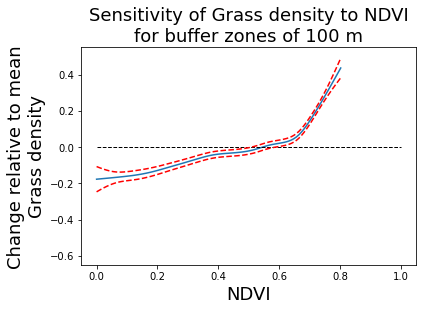

In [100]:
# plotting best grass_100 model
for i, term in enumerate(uni_gam_100_8.terms):
    if term.isintercept:
        continue

    XX = uni_gam_100_8.generate_X_grid(term=i)
    pdep, confi = uni_gam_100_8.partial_dependence(term=i, X=XX, width=0.95)

    plt.figure()
    plt.plot(XX[:, term.feature], pdep)
    plt.hlines(y=0, xmin=0, xmax=1, linewidth=1, color='black', linestyle='--')
    plt.plot(XX[:, term.feature], confi, c='r', ls='--')
    ax = plt.gca()
    ax.set_ylim([-0.65, 0.55])
    # set title, xlabel and ylabel
    plt.title('Sensitivity of Grass density to NDVI\nfor buffer zones of 100 m', fontsize=18)
    plt.xlabel('NDVI', fontsize=18)
    plt.ylabel('Change relative to mean\nGrass density', fontsize=18)
    # save the figure
    plt.savefig('thesis_project/visualizations/modelling/univariate/gam_grass_100_best_plot_2.png', dpi=300, bbox_inches='tight')
    im.open('thesis_project/visualizations/modelling/univariate/gam_grass_100_best_plot_2.png').save('thesis_project/visualizations/modelling/univariate/gam_grass_100_best_plot_2.bmp')
    plt.show()

In [131]:
# Change in low NDVI values: how does Grass% increase, if NDVI changes from 0.25 to 0.35?
grass_l0 = uni_gam_100_8.predict(0.20)
grass_l1 = uni_gam_100_8.predict(0.30)
grass_sens_low = float(grass_l1 - grass_l0)
print('If NDVI goes from 0.25 to 0.35, Grass%_100 increases by:', grass_sens_low)

If NDVI goes from 0.25 to 0.35, Grass%_100 increases by: 0.04838241050848764


In [132]:
# Change in mid NDVI values: how does Grass% increase, if NDVI changes from 0.45 to 0.55?
grass_m0 = uni_gam_100_8.predict(0.4)
grass_m1 = uni_gam_100_8.predict(0.5)
grass_sens_mid = float(grass_m1 - grass_m0)
print('If NDVI goes from 0.45 to 0.55, Grass%_100 increases by:', grass_sens_mid)

If NDVI goes from 0.45 to 0.55, Grass%_100 increases by: 0.017751675654094162


In [133]:
# Change in high NDVI values: how does Grass% increase, if NDVI changes from 0.65 to 0.75?
grass_h0 = uni_gam_100_8.predict(0.6)
grass_h1 = uni_gam_100_8.predict(0.7)
grass_sens_hig = float(grass_h1 - grass_h0)
print('If NDVI goes from 0.65 to 0.75, Grass%_100 increases by:', grass_sens_hig)

If NDVI goes from 0.65 to 0.75, Grass%_100 increases by: 0.12305952325462363


## 2. Modeling vegetation densities for buffer distances of 300 meters

In [32]:
# load greenspace metrics at 300m geodataframe
gdf_300 = gpd.read_file("thesis_project/output/dataframes/greenspace_metrics_300_df_2.json")
gdf_300.head()

,NDVI_300,Greenspace%_300,Canopy%_300,Grass%_300,Shrubs%_300,geometry
0,0.280478,0.326412,0.145660,0.080623,0.097554,POINT (387760.076 393972.512)
1,0.503846,0.847073,0.062886,0.391561,0.387530,POINT (361558.182 408801.964)
2,0.589265,0.831569,0.104542,0.243752,0.480785,POINT (391126.815 417220.287)
3,0.493672,0.796394,0.127654,0.150497,0.513034,POINT (361327.964 411390.899)
4,0.343043,0.610614,0.275732,0.147272,0.190540,POINT (377099.280 400575.430)


### 2.1. Model 1: greenspace ~ linear(NDVI)

In [33]:
# data/predictors as the NDVI_300
df_300 = pd.DataFrame(gdf_300, columns=['NDVI_300'])

# target as Greenspace%_300
target_300 = pd.DataFrame(gdf_300, columns=['Greenspace%_300'])

# define X and Y
X = df_300
y = target_300['Greenspace%_300']

# split independent and dependent variables into training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [34]:
# Model 1
warnings.filterwarnings("ignore", category=RuntimeWarning)
uni_gam_300_1 = LinearGAM(l(0)).fit(X_train, y_train)

uni_gam_300_1.gridsearch(X_train, y_train)
uni_gam_300_1.summary()

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      1.9998
Link Function:                     IdentityLink Log Likelihood:                               -118115.4594
Number of Samples:                         4656 AIC:                                           236236.9183
                                                AICc:                                          236236.9235
                                                GCV:                                                0.0176
                                                Scale:                                              0.0175
                                                Pseudo R-Squared:                                   0.6762
Feature Function                  Lam

/var/folders/6g/kgz5rml118s6lqw25w5sv5mr0000gn/T/ipykernel_1007/1216624643.py:6: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  uni_gam_300_1.summary()


### 2.2. Model 2: greenspace ~ spline(NDVI)

In [35]:
# Model 2
warnings.filterwarnings("ignore", category=RuntimeWarning)
uni_gam_300_2 = LinearGAM(s(0)).fit(X_train, y_train)

uni_gam_300_2.gridsearch(X_train, y_train)
uni_gam_300_2.summary()

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      7.6496
Link Function:                     IdentityLink Log Likelihood:                               -128043.4791
Number of Samples:                         4656 AIC:                                           256104.2573
                                                AICc:                                          256104.2933
                                                GCV:                                                0.0163
                                                Scale:                                              0.0163
                                                Pseudo R-Squared:                                   0.7002
Feature Function                  Lam

/var/folders/6g/kgz5rml118s6lqw25w5sv5mr0000gn/T/ipykernel_1007/3283538479.py:6: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  uni_gam_300_2.summary()


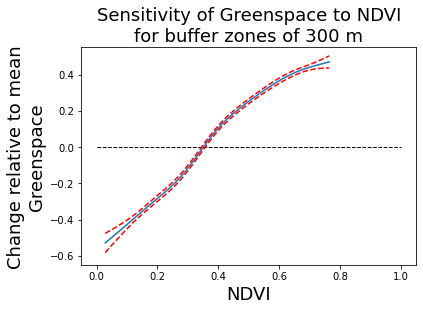

In [101]:
# plotting best greenspace_300 model
for i, term in enumerate(uni_gam_300_2.terms):
    if term.isintercept:
        continue

    XX = uni_gam_300_2.generate_X_grid(term=i)
    pdep, confi = uni_gam_300_2.partial_dependence(term=i, X=XX, width=0.95)

    plt.figure()
    plt.plot(XX[:, term.feature], pdep)
    plt.hlines(y=0, xmin=0, xmax=1, linewidth=1, color='black', linestyle='--')
    plt.plot(XX[:, term.feature], confi, c='r', ls='--')
    ax = plt.gca()
    ax.set_ylim([-0.65, 0.55])
    # set title, xlabel and ylabel
    plt.title('Sensitivity of Greenspace to NDVI\nfor buffer zones of 300 m', fontsize=18)
    plt.xlabel('NDVI', fontsize=18)
    plt.ylabel('Change relative to mean\nGreenspace', fontsize=18)
    # save the figure
    plt.savefig('thesis_project/visualizations/modelling/univariate/gam_greenspace_300_best_plot_2.png', dpi=300, bbox_inches='tight')
    im.open('thesis_project/visualizations/modelling/univariate/gam_greenspace_300_best_plot_2.png').save('thesis_project/visualizations/modelling/univariate/gam_greenspace_300_best_plot_2.bmp')
    plt.show()

In [134]:
# Change in low NDVI values: how does Greenspace% increase, if NDVI changes from 0.25 to 0.35?
green_l0 = uni_gam_300_2.predict(0.2)
green_l1 = uni_gam_300_2.predict(0.3)
green_sens_low_300 = float(green_l1 - green_l0)
print('If NDVI goes from 0.25 to 0.35, Greenspace%_300 increases by:', green_sens_low_300)

If NDVI goes from 0.25 to 0.35, Greenspace%_300 increases by: 0.16708961466717198


In [135]:
# Change in mid NDVI values: how does Greenspace% increase, if NDVI changes from 0.45 to 0.55?
green_m0 = uni_gam_300_2.predict(0.4)
green_m1 = uni_gam_300_2.predict(0.5)
green_sens_mid_300 = float(green_m1 - green_m0)
print('If NDVI goes from 0.45 to 0.55, Greenspace%_300 increases by:', green_sens_mid_300)

If NDVI goes from 0.45 to 0.55, Greenspace%_300 increases by: 0.14772700545627215


In [136]:
# Change in high NDVI values: how does Greenspace% increase, if NDVI changes from 0.65 to 0.75?
green_h0 = uni_gam_300_2.predict(0.6)
green_h1 = uni_gam_300_2.predict(0.7)
green_sens_hig_300 = float(green_h1 - green_h0)
print('If NDVI goes from 0.65 to 0.75, Greenspace%_300 increases by:', green_sens_hig_300)

If NDVI goes from 0.65 to 0.75, Greenspace%_300 increases by: 0.07458566958684576


### 2.3. Model 3: tree canopy ~ linear(NDVI)

In [40]:
# NDVI_300 as the predictor
df = pd.DataFrame(gdf_300, columns=['NDVI_300'])

# Canopy%_300 as the target
target = pd.DataFrame(gdf_300, columns=['Canopy%_300'])

# define X and y
X = df
y = target['Canopy%_300']

# split independent and dependent variables into training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# fit the linear model
lm_300 = linear_model.LinearRegression()
model_300 = lm_300.fit(X_train,y_train)

In [41]:
# Model 3
warnings.filterwarnings("ignore", category=RuntimeWarning)
uni_gam_300_3 = LinearGAM(l(0)).fit(X_train, y_train)

uni_gam_300_3.gridsearch(X_train, y_train)
uni_gam_300_3.summary()

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      1.9924
Link Function:                     IdentityLink Log Likelihood:                               -119751.0474
Number of Samples:                         4656 AIC:                                           239508.0794
                                                AICc:                                          239508.0846
                                                GCV:                                                0.0173
                                                Scale:                                              0.0173
                                                Pseudo R-Squared:                                   0.0403
Feature Function                  Lam

/var/folders/6g/kgz5rml118s6lqw25w5sv5mr0000gn/T/ipykernel_1007/1162806293.py:6: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  uni_gam_300_3.summary()


### 2.4. Model 4: tree canopy ~ spline(NDVI)

In [42]:
# Model 4
warnings.filterwarnings("ignore", category=RuntimeWarning)
uni_gam_300_4 = LinearGAM(s(0)).fit(X_train, y_train)

uni_gam_300_4.gridsearch(X_train, y_train)
uni_gam_300_4.summary()

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      5.8758
Link Function:                     IdentityLink Log Likelihood:                               -124323.8803
Number of Samples:                         4656 AIC:                                           248661.5122
                                                AICc:                                          248661.5355
                                                GCV:                                                0.0168
                                                Scale:                                              0.0167
                                                Pseudo R-Squared:                                   0.0745
Feature Function                  Lam

/var/folders/6g/kgz5rml118s6lqw25w5sv5mr0000gn/T/ipykernel_1007/2529495405.py:6: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  uni_gam_300_4.summary()


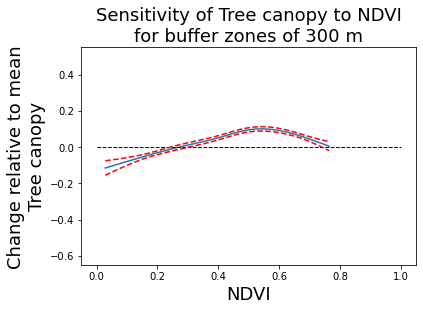

In [102]:
# plotting
for i, term in enumerate(uni_gam_300_4.terms):
    if term.isintercept:
        continue

    XX = uni_gam_300_4.generate_X_grid(term=i)
    pdep, confi = uni_gam_300_4.partial_dependence(term=i, X=XX, width=0.95)

    plt.figure()
    plt.plot(XX[:, term.feature], pdep)
    plt.hlines(y=0, xmin=0, xmax=1, linewidth=1, color='black', linestyle='--')
    plt.plot(XX[:, term.feature], confi, c='r', ls='--')
    ax = plt.gca()
    ax.set_ylim([-0.65, 0.55])
    # set title, xlabel and ylabel
    plt.title('Sensitivity of Tree canopy to NDVI\nfor buffer zones of 300 m', fontsize=18)
    plt.xlabel('NDVI', fontsize=18)
    plt.ylabel('Change relative to mean\nTree canopy', fontsize=18)
    # save the figure
    plt.savefig('thesis_project/visualizations/modelling/univariate/gam_canopy_300_best_plot_2.png', dpi=300, bbox_inches='tight')
    im.open('thesis_project/visualizations/modelling/univariate/gam_canopy_300_best_plot_2.png').save('thesis_project/visualizations/modelling/univariate/gam_canopy_300_best_plot_2.bmp')
    plt.show()

In [137]:
# Change in low NDVI values: how does Canopy% increase, if NDVI changes from 0.25 to 0.35?
canopy_l0 = uni_gam_300_4.predict(0.2)
canopy_l1 = uni_gam_300_4.predict(0.3)
canopy_sens_low_300 = float(canopy_l1 - canopy_l0)
print('If NDVI goes from 0.25 to 0.35, Canopy%_300 increases by:', canopy_sens_low_300)

If NDVI goes from 0.25 to 0.35, Canopy%_300 increases by: 0.042208439088218475


In [138]:
# Change in mid NDVI values: how does Canopy% increase, if NDVI changes from 0.45 to 0.55?
canopy_m0 = uni_gam_300_4.predict(0.4)
canopy_m1 = uni_gam_300_4.predict(0.5)
canopy_sens_mid_300 = float(canopy_m1 - canopy_m0)
print('If NDVI goes from 0.45 to 0.55, Canopy%_300 increases by:', canopy_sens_mid_300)

If NDVI goes from 0.45 to 0.55, Canopy%_300 increases by: 0.043816312708352845


In [139]:
# Change in high NDVI values: how does Canopy% increase, if NDVI changes from 0.65 to 0.75?
canopy_h0 = uni_gam_300_4.predict(0.6)
canopy_h1 = uni_gam_300_4.predict(0.7)
canopy_sens_hig_300 = float(canopy_h1 - canopy_h0)
print('If NDVI goes from 0.65 to 0.75, Canopy%_300 increases by:', canopy_sens_hig_300)

If NDVI goes from 0.65 to 0.75, Canopy%_300 increases by: -0.04711510591714471


### 2.5. Model 5: forbs and shrubs ~ linear(NDVI)

In [47]:
# data/predictors as the NDVI_300
df_300 = pd.DataFrame(gdf_300, columns=['NDVI_300'])

# target as Shrubs%_300
target_300 = pd.DataFrame(gdf_300, columns=['Shrubs%_300'])

# define X and y
X = df_300
y = target_300['Shrubs%_300']

# split independent and dependent variables into training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# fit the linear model
lm_300 = linear_model.LinearRegression()
model_300 = lm_300.fit(X_train,y_train)

In [48]:
# Model 5
warnings.filterwarnings("ignore", category=RuntimeWarning)
uni_gam_300_5 = LinearGAM(l(0)).fit(X_train, y_train)

uni_gam_300_5.gridsearch(X_train, y_train)
uni_gam_300_5.summary()

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      1.9992
Link Function:                     IdentityLink Log Likelihood:                                -39207.7892
Number of Samples:                         4656 AIC:                                            78421.5767
                                                AICc:                                           78421.5819
                                                GCV:                                                0.0474
                                                Scale:                                              0.0474
                                                Pseudo R-Squared:                                   0.1753
Feature Function                  Lam

/var/folders/6g/kgz5rml118s6lqw25w5sv5mr0000gn/T/ipykernel_1007/2500949949.py:6: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  uni_gam_300_5.summary()


### 2.6. Model 6: forbs and shrubs ~ spline(NDVI)

In [49]:
# Model 6
warnings.filterwarnings("ignore", category=RuntimeWarning)
uni_gam_300_6 = LinearGAM(s(0)).fit(X_train, y_train)

uni_gam_300_6.gridsearch(X_train, y_train)
uni_gam_300_6.summary()

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      7.6496
Link Function:                     IdentityLink Log Likelihood:                                -39581.6776
Number of Samples:                         4656 AIC:                                            79180.6545
                                                AICc:                                           79180.6904
                                                GCV:                                                 0.047
                                                Scale:                                              0.0469
                                                Pseudo R-Squared:                                   0.1842
Feature Function                  Lam

/var/folders/6g/kgz5rml118s6lqw25w5sv5mr0000gn/T/ipykernel_1007/1093988074.py:6: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  uni_gam_300_6.summary()


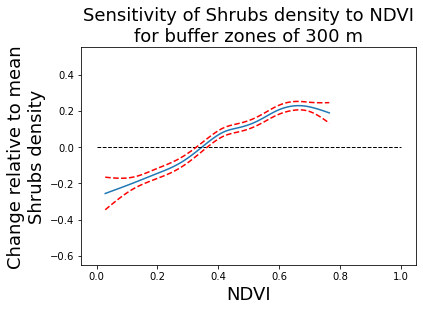

In [103]:
# plotting
for i, term in enumerate(uni_gam_300_6.terms):
    if term.isintercept:
        continue

    XX = uni_gam_300_6.generate_X_grid(term=i)
    pdep, confi = uni_gam_300_6.partial_dependence(term=i, X=XX, width=0.95)

    plt.figure()
    plt.plot(XX[:, term.feature], pdep)
    plt.hlines(y=0, xmin=0, xmax=1, linewidth=1, color='black', linestyle='--')
    plt.plot(XX[:, term.feature], confi, c='r', ls='--')
    ax = plt.gca()
    ax.set_ylim([-0.65, 0.55])
    # set title, xlabel and ylabel
    plt.title('Sensitivity of Shrubs density to NDVI\nfor buffer zones of 300 m', fontsize=18)
    plt.xlabel('NDVI', fontsize=18)
    plt.ylabel('Change relative to mean\nShrubs density', fontsize=18)
    # save the figure
    plt.savefig('thesis_project/visualizations/modelling/univariate/gam_shrubs_300_best_plot_2.png', dpi=300, bbox_inches='tight')
    im.open('thesis_project/visualizations/modelling/univariate/gam_shrubs_300_best_plot_2.png').save('thesis_project/visualizations/modelling/univariate/gam_shrubs_300_best_plot_2.bmp')
    plt.show()

In [140]:
# Change in low NDVI values: how does shrubs% increase, if NDVI changes from 0.25 to 0.35?
shrubs_l0 = uni_gam_300_6.predict(0.2)
shrubs_l1 = uni_gam_300_6.predict(0.3)
shrubs_sens_low_300 = float(shrubs_l1 - shrubs_l0)
print('If NDVI goes from 0.25 to 0.35, shrubs%_300 increases by:', shrubs_sens_low_300)

If NDVI goes from 0.25 to 0.35, shrubs%_300 increases by: 0.0849148035086395


In [141]:
# Change in mid NDVI values: how does shrubs% increase, if NDVI changes from 0.45 to 0.55?
shrubs_m0 = uni_gam_300_6.predict(0.4)
shrubs_m1 = uni_gam_300_6.predict(0.5)
shrubs_sens_mid_300 = float(shrubs_m1 - shrubs_m0)
print('If NDVI goes from 0.45 to 0.55, shrubs%_300 increases by:', shrubs_sens_mid_300)

If NDVI goes from 0.45 to 0.55, shrubs%_300 increases by: 0.055604244987157214


In [142]:
# Change in high NDVI values: how does shrubs% increase, if NDVI changes from 0.65 to 0.75?
shrubs_h0 = uni_gam_300_6.predict(0.6)
shrubs_h1 = uni_gam_300_6.predict(0.7)
shrubs_sens_hig_300 = float(shrubs_h1 - shrubs_h0)
print('If NDVI goes from 0.65 to 0.75, shrubs%_300 increases by:', shrubs_sens_hig_300)

If NDVI goes from 0.65 to 0.75, shrubs%_300 increases by: 0.015122301316151776


### 2.7. Model 7: grass ~ linear(NDVI)

In [54]:
# NDVI_300 as the predictor
df = pd.DataFrame(gdf_300, columns=['NDVI_300'])

# Grass%_300 as the target
target = pd.DataFrame(gdf_300, columns=['Grass%_300'])

# define X and y
X = df
y = target['Grass%_300']

# split independent and dependent variables into training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# fit the linear model
lm_300 = linear_model.LinearRegression()
model_300 = lm_300.fit(X_train,y_train)

In [55]:
# Model 7
warnings.filterwarnings("ignore", category=RuntimeWarning)
uni_gam_300_7 = LinearGAM(l(0)).fit(X_train, y_train)

uni_gam_300_7.gridsearch(X_train, y_train)
uni_gam_300_7.summary()

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
/var/folders/6g/kgz5rml118s6lqw25w5sv5mr0000gn/T/ipykernel_1007/277399172.py:6: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  uni_gam_300_7.summary()


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      1.9992
Link Function:                     IdentityLink Log Likelihood:                               -204349.6362
Number of Samples:                         4656 AIC:                                           408705.2708
                                                AICc:                                           408705.276
                                                GCV:                                                0.0105
                                                Scale:                                              0.0105
                                                Pseudo R-Squared:                                   0.2563
Feature Function                  Lam

### 2.8. Model 8: grass ~ spline(NDVI)

In [56]:
# Model 8
warnings.filterwarnings("ignore", category=RuntimeWarning)
uni_gam_300_8 = LinearGAM(s(0)).fit(X_train, y_train)

uni_gam_300_8.gridsearch(X_train, y_train)
uni_gam_300_8.summary()

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      7.6496
Link Function:                     IdentityLink Log Likelihood:                               -207895.5869
Number of Samples:                         4656 AIC:                                            415808.473
                                                AICc:                                          415808.5089
                                                GCV:                                                0.0104
                                                Scale:                                              0.0103
                                                Pseudo R-Squared:                                     0.27
Feature Function                  Lam

/var/folders/6g/kgz5rml118s6lqw25w5sv5mr0000gn/T/ipykernel_1007/68270352.py:6: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  uni_gam_300_8.summary()


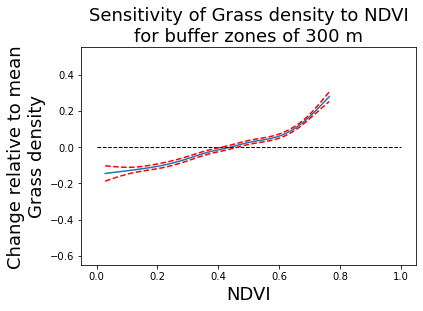

In [104]:
# plotting
for i, term in enumerate(uni_gam_300_8.terms):
    if term.isintercept:
        continue

    XX = uni_gam_300_8.generate_X_grid(term=i)
    pdep, confi = uni_gam_300_8.partial_dependence(term=i, X=XX, width=0.95)

    plt.figure()
    plt.plot(XX[:, term.feature], pdep)
    plt.hlines(y=0, xmin=0, xmax=1, linewidth=1, color='black', linestyle='--')
    plt.plot(XX[:, term.feature], confi, c='r', ls='--')
    ax = plt.gca()
    ax.set_ylim([-0.65, 0.55])
    # set title, xlabel and ylabel
    plt.title('Sensitivity of Grass density to NDVI\nfor buffer zones of 300 m', fontsize=18)
    plt.xlabel('NDVI', fontsize=18)
    plt.ylabel('Change relative to mean\nGrass density', fontsize=18)
    # save the figure
    plt.savefig('thesis_project/visualizations/modelling/univariate/gam_grass_300_best_plot_2.png', dpi=300, bbox_inches='tight')
    im.open('thesis_project/visualizations/modelling/univariate/gam_grass_300_best_plot_2.png').save('thesis_project/visualizations/modelling/univariate/gam_grass_300_best_plot_2.bmp')


    plt.show()

In [143]:
# Change in low NDVI values: how does Grass% increase, if NDVI changes from 0.25 to 0.35?
grass_l0 = uni_gam_300_8.predict(0.2)
grass_l1 = uni_gam_300_8.predict(0.3)
grass_sens_low_300 = float(grass_l1 - grass_l0)
print('If NDVI goes from 0.25 to 0.35, Grass%_300 increases by:', grass_sens_low_300)

If NDVI goes from 0.25 to 0.35, Grass%_300 increases by: 0.04291982509477453


In [144]:
# Change in mid NDVI values: how does Grass% increase, if NDVI changes from 0.45 to 0.55?
grass_m0 = uni_gam_300_8.predict(0.4)
grass_m1 = uni_gam_300_8.predict(0.5)
grass_sens_mid_300 = float(grass_m1 - grass_m0)
print('If NDVI goes from 0.45 to 0.55, Grass%_300 increases by:', grass_sens_mid_300)

If NDVI goes from 0.45 to 0.55, Grass%_300 increases by: 0.04066750806211014


In [145]:
# Change in hig NDVI values: how does Grass% increase, if NDVI changes from 0.65 to 0.75?
grass_h0 = uni_gam_300_8.predict(0.6)
grass_h1 = uni_gam_300_8.predict(0.7)
grass_sens_hig_300 = float(grass_h1 - grass_h0)
print('If NDVI goes from 0.65 to 0.75, Grass%_300 increases by:', grass_sens_hig_300)

If NDVI goes from 0.65 to 0.75, Grass%_300 increases by: 0.10783165280396259


## 3. Modeling vegetation densities for buffer distances of 500 meters

In [61]:
# load greenspace metrics at 500m geodataframe
gdf_500 = gpd.read_file("thesis_project/output/dataframes/greenspace_metrics_500_df_2.json")
gdf_500.head()

,NDVI_500,Greenspace%_500,Canopy%_500,Grass%_500,Shrubs%_500,geometry
0,0.407077,0.982575,0.006176,0.028919,0.947064,POINT (401901.359 408671.581)
1,0.441260,0.575357,0.167827,0.131850,0.277816,POINT (368835.367 407479.786)
2,0.312300,0.395262,0.212136,0.095873,0.087050,POINT (377751.293 401260.842)
3,0.283220,0.355313,0.098324,0.070777,0.188119,POINT (391535.548 395524.756)
4,0.552286,0.770303,0.265954,0.094795,0.409666,POINT (369836.790 402258.456)


### 3.1. Model 1: greenspace ~ linear(NDVI)

In [62]:
# NDVI_500 as the predictor
df = pd.DataFrame(gdf_500, columns=['NDVI_500'])

# Greenspace%_300 as the target
target = pd.DataFrame(gdf_500, columns=['Greenspace%_500'])

# define X and y
X = df
y = target['Greenspace%_500']

# split independent and dependent variables into training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# fit the linear model
lm_500 = linear_model.LinearRegression()
model_500 = lm_500.fit(X_train,y_train)

In [63]:
# Model 1
warnings.filterwarnings("ignore", category=RuntimeWarning)
uni_gam_500_1 = LinearGAM(l(0)).fit(X_train, y_train)

uni_gam_500_1.gridsearch(X_train, y_train)
uni_gam_500_1.summary()

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      1.9999
Link Function:                     IdentityLink Log Likelihood:                                -68708.8381
Number of Samples:                         2316 AIC:                                           137423.6759
                                                AICc:                                          137423.6863
                                                GCV:                                                0.0152
                                                Scale:                                              0.0152
                                                Pseudo R-Squared:                                   0.6684
Feature Function                  Lam

/var/folders/6g/kgz5rml118s6lqw25w5sv5mr0000gn/T/ipykernel_1007/2474993179.py:6: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  uni_gam_500_1.summary()


### 3.2. Model 2: greenspace ~ spline(NDVI)

In [64]:
# Model 2
warnings.filterwarnings("ignore", category=RuntimeWarning)
uni_gam_500_2 = LinearGAM(s(0)).fit(X_train, y_train)

uni_gam_500_2.gridsearch(X_train, y_train)
uni_gam_500_2.summary()

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      8.8225
Link Function:                     IdentityLink Log Likelihood:                                 -74296.051
Number of Samples:                         2316 AIC:                                            148611.747
                                                AICc:                                          148611.8392
                                                GCV:                                                0.0142
                                                Scale:                                              0.0141
                                                Pseudo R-Squared:                                   0.6935
Feature Function                  Lam

/var/folders/6g/kgz5rml118s6lqw25w5sv5mr0000gn/T/ipykernel_1007/3753528684.py:6: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  uni_gam_500_2.summary()


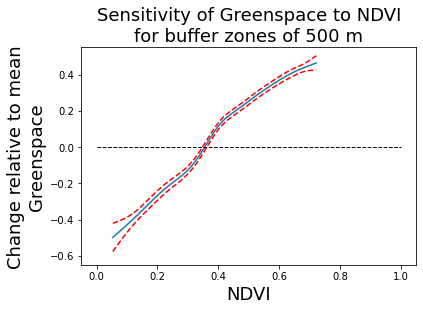

In [105]:
# plotting
for i, term in enumerate(uni_gam_500_2.terms):
    if term.isintercept:
        continue

    XX = uni_gam_500_2.generate_X_grid(term=i)
    pdep, confi = uni_gam_500_2.partial_dependence(term=i, X=XX, width=0.95)

    plt.figure()
    plt.plot(XX[:, term.feature], pdep)
    plt.hlines(y=0, xmin=0, xmax=1, linewidth=1, color='black', linestyle='--')
    plt.plot(XX[:, term.feature], confi, c='r', ls='--')
    ax = plt.gca()
    ax.set_ylim([-0.65, 0.55])
    # set title, xlabel and ylabel
    plt.title('Sensitivity of Greenspace to NDVI\nfor buffer zones of 500 m', fontsize=18)
    plt.xlabel('NDVI', fontsize=18)
    plt.ylabel('Change relative to mean\nGreenspace', fontsize=18)
    # save the figure
    plt.savefig('thesis_project/visualizations/modelling/univariate/gam_greenspace_500_best_plot_2.png', dpi=300, bbox_inches='tight')
    im.open('thesis_project/visualizations/modelling/univariate/gam_greenspace_500_best_plot_2.png').save('thesis_project/visualizations/modelling/univariate/gam_greenspace_500_best_plot_2.bmp')
    plt.show()

In [146]:
# Change in low NDVI values: how does Greenspace% increase, if NDVI changes from 0.25 to 0.35?
green_l0 = uni_gam_500_2.predict(0.2)
green_l1 = uni_gam_500_2.predict(0.3)
green_sens_low_500 = float(green_l1 - green_l0)
print('If NDVI goes from 0.25 to 0.35, Greenspace%_500 increases by:', green_sens_low_500)

If NDVI goes from 0.25 to 0.35, Greenspace%_500 increases by: 0.1405613918601712


In [147]:
# Change in medium NDVI values: how does Greenspace% increase, if NDVI changes from 0.45 to 0.55?
green_m0 = uni_gam_500_2.predict(0.4)
green_m1 = uni_gam_500_2.predict(0.5)
green_sens_mid_500 = float(green_m1 - green_m0)
print('If NDVI goes from 0.45 to 0.55, Greenspace%_500 increases by:', green_sens_mid_500)

If NDVI goes from 0.45 to 0.55, Greenspace%_500 increases by: 0.13795851063273912


In [148]:
# Change in high NDVI values: how does Greenspace% increase, if NDVI changes from 0.65 to 0.75?
green_h0 = uni_gam_500_2.predict(0.6)
green_h1 = uni_gam_500_2.predict(0.7)
green_sens_hig_500 = float(green_h1 - green_h0)
print('If NDVI goes from 0.65 to 0.75, Greenspace%_500 increases by:', green_sens_hig_500)

If NDVI goes from 0.65 to 0.75, Greenspace%_500 increases by: 0.08164082798287908


### 3.3. Model 3: tree canopy ~ linear(NDVI)

In [69]:
# NDVI_500 as the predictor
df = pd.DataFrame(gdf_500, columns=['NDVI_500'])

# Greenspace%_300 as the target
target = pd.DataFrame(gdf_500, columns=['Canopy%_500'])

# define X and y
X = df
y = target['Canopy%_500']

# split independent and dependent variables into training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# fit the linear model
lm_500 = linear_model.LinearRegression()
model_500 = lm_500.fit(X_train,y_train)

In [70]:
# Model 3
warnings.filterwarnings("ignore", category=RuntimeWarning)
uni_gam_500_3 = LinearGAM(l(0)).fit(X_train, y_train)

uni_gam_500_3.gridsearch(X_train, y_train)
uni_gam_500_3.summary()

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      1.9812
Link Function:                     IdentityLink Log Likelihood:                                -82627.5544
Number of Samples:                         2316 AIC:                                           165261.0713
                                                AICc:                                          165261.0815
                                                GCV:                                                0.0128
                                                Scale:                                              0.0128
                                                Pseudo R-Squared:                                   0.0309
Feature Function                  Lam

/var/folders/6g/kgz5rml118s6lqw25w5sv5mr0000gn/T/ipykernel_1007/2840720071.py:6: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  uni_gam_500_3.summary()


### 3.4. Model 4: tree canopy ~ spline(NDVI)

In [71]:
# Model 4
warnings.filterwarnings("ignore", category=RuntimeWarning)
uni_gam_500_4 = LinearGAM(s(0)).fit(X_train, y_train)

uni_gam_500_4.gridsearch(X_train, y_train)
uni_gam_500_4.summary()

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      6.8256
Link Function:                     IdentityLink Log Likelihood:                                -84808.3044
Number of Samples:                         2316 AIC:                                           169632.2598
                                                AICc:                                          169632.3197
                                                GCV:                                                0.0125
                                                Scale:                                              0.0124
                                                Pseudo R-Squared:                                   0.0582
Feature Function                  Lam

/var/folders/6g/kgz5rml118s6lqw25w5sv5mr0000gn/T/ipykernel_1007/3479331719.py:6: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  uni_gam_500_4.summary()


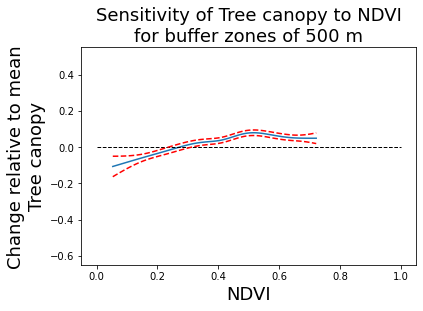

In [106]:
# plotting
for i, term in enumerate(uni_gam_500_4.terms):
    if term.isintercept:
        continue

    XX = uni_gam_500_4.generate_X_grid(term=i)
    pdep, confi = uni_gam_500_4.partial_dependence(term=i, X=XX, width=0.95)

    plt.figure()
    plt.plot(XX[:, term.feature], pdep)
    plt.hlines(y=0, xmin=0, xmax=1, linewidth=1, color='black', linestyle='--')
    plt.plot(XX[:, term.feature], confi, c='r', ls='--')
    ax = plt.gca()
    ax.set_ylim([-0.65, 0.55])
    # set title, xlabel and ylabel
    plt.title('Sensitivity of Tree canopy to NDVI\nfor buffer zones of 500 m', fontsize=18)
    plt.xlabel('NDVI', fontsize=18)
    plt.ylabel('Change relative to mean\nTree canopy', fontsize=18)
    # save the figure
    plt.savefig('thesis_project/visualizations/modelling/univariate/gam_canopy_500_best_plot_2.png', dpi=300, bbox_inches='tight')
    im.open('thesis_project/visualizations/modelling/univariate/gam_canopy_500_best_plot_2.png').save('thesis_project/visualizations/modelling/univariate/gam_canopy_500_best_plot_2.bmp')
    plt.show()

In [149]:
# Change in low NDVI values: how does Canopy% increase, if NDVI changes from 0.25 to 0.35?
canopy_l0 = uni_gam_500_4.predict(0.2)
canopy_l1 = uni_gam_500_4.predict(0.3)
canopy_sens_low_500 = float(canopy_l1 - canopy_l0)
print('If NDVI goes from 0.25 to 0.35, canopy%_500 increases by:', canopy_sens_low_500)

If NDVI goes from 0.25 to 0.35, canopy%_500 increases by: 0.047297824935435315


In [150]:
# Change in medium NDVI values: how does canopy% increase, if NDVI changes from 0.45 to 0.55?
canopy_m0 = uni_gam_500_4.predict(0.4)
canopy_m1 = uni_gam_500_4.predict(0.5)
canopy_sens_mid_500 = float(canopy_m1 - canopy_m0)
print('If NDVI goes from 0.45 to 0.55, canopy%_500 increases by:', canopy_sens_mid_500)

If NDVI goes from 0.45 to 0.55, canopy%_500 increases by: 0.04245781300167431


In [151]:
# Change in high NDVI values: how does canopy% increase, if NDVI changes from 0.65 to 0.75?
canopy_h0 = uni_gam_500_4.predict(0.6)
canopy_h1 = uni_gam_500_4.predict(0.7)
canopy_sens_hig_500 = float(canopy_h1 - canopy_h0)
print('If NDVI goes from 0.65 to 0.75, canopy%_500 increases by:', canopy_sens_hig_500)

If NDVI goes from 0.65 to 0.75, canopy%_500 increases by: -0.011118977468192959


### 3.5. Model 5: forbs and shrubs ~ linear(NDVI)

In [76]:
# NDVI_500 as the predictor
df = pd.DataFrame(gdf_500, columns=['NDVI_500'])

# Shrubs%_500 as the target
target = pd.DataFrame(gdf_500, columns=['Shrubs%_500'])

# define X and y
X = df
y = target['Shrubs%_500']

# split independent and dependent variables into training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# fit the linear model
lm_500 = linear_model.LinearRegression()
model_500 = lm_500.fit(X_train,y_train)

In [77]:
# Model 5
warnings.filterwarnings("ignore", category=RuntimeWarning)
uni_gam_500_5 = LinearGAM(l(0)).fit(X_train, y_train)

uni_gam_500_5.gridsearch(X_train, y_train)
uni_gam_500_5.summary()

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                       1.998
Link Function:                     IdentityLink Log Likelihood:                                -23525.4931
Number of Samples:                         2316 AIC:                                            47056.9821
                                                AICc:                                           47056.9925
                                                GCV:                                                0.0402
                                                Scale:                                              0.0401
                                                Pseudo R-Squared:                                   0.1777
Feature Function                  Lam

/var/folders/6g/kgz5rml118s6lqw25w5sv5mr0000gn/T/ipykernel_1007/405054797.py:6: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  uni_gam_500_5.summary()


### 3.6. Model 6: forbs and shrubs ~ spline(NDVI)

In [78]:
# Model 6
warnings.filterwarnings("ignore", category=RuntimeWarning)
uni_gam_500_6 = LinearGAM(s(0)).fit(X_train, y_train)

uni_gam_500_6.gridsearch(X_train, y_train)
uni_gam_500_6.summary()

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      8.8225
Link Function:                     IdentityLink Log Likelihood:                                -23940.5195
Number of Samples:                         2316 AIC:                                            47900.6838
                                                AICc:                                           47900.7761
                                                GCV:                                                0.0396
                                                Scale:                                              0.0394
                                                Pseudo R-Squared:                                   0.1953
Feature Function                  Lam

/var/folders/6g/kgz5rml118s6lqw25w5sv5mr0000gn/T/ipykernel_1007/2335926396.py:6: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  uni_gam_500_6.summary()


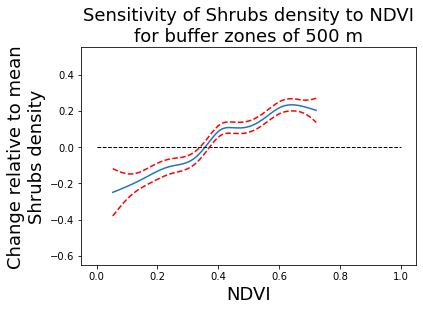

In [107]:
# plotting
for i, term in enumerate(uni_gam_500_6.terms):
    if term.isintercept:
        continue

    XX = uni_gam_500_6.generate_X_grid(term=i)
    pdep, confi = uni_gam_500_6.partial_dependence(term=i, X=XX, width=0.95)

    plt.figure()
    plt.plot(XX[:, term.feature], pdep)
    plt.hlines(y=0, xmin=0, xmax=1, linewidth=1, color='black', linestyle='--')
    plt.plot(XX[:, term.feature], confi, c='r', ls='--')
    ax = plt.gca()
    ax.set_ylim([-0.65, 0.55])
    # set title, xlabel and ylabel
    plt.title('Sensitivity of Shrubs density to NDVI\nfor buffer zones of 500 m', fontsize=18)
    plt.xlabel('NDVI', fontsize=18)
    plt.ylabel('Change relative to mean\nShrubs density', fontsize=18)
    # save the figure
    plt.savefig('thesis_project/visualizations/modelling/univariate/gam_shrubs_500_best_plot_2.png', dpi=300, bbox_inches='tight')
    im.open('thesis_project/visualizations/modelling/univariate/gam_shrubs_500_best_plot_2.png').save('thesis_project/visualizations/modelling/univariate/gam_shrubs_500_best_plot_2.bmp')
    plt.show()

In [152]:
# Change in low NDVI values: how does shrubs% increase, if NDVI changes from 0.25 to 0.35?
shrubs_l0 = uni_gam_500_6.predict(0.2)
shrubs_l1 = uni_gam_500_6.predict(0.3)
shrubs_sens_low_500 = float(shrubs_l1 - shrubs_l0)
print('If NDVI goes from 0.25 to 0.35, shrubs%_500 increases by:', shrubs_sens_low_500)

If NDVI goes from 0.25 to 0.35, shrubs%_500 increases by: 0.05029990817324037


In [153]:
# Change in medium NDVI values: how does shrubs% increase, if NDVI changes from 0.45 to 0.55?
shrubs_m0 = uni_gam_500_6.predict(0.4)
shrubs_m1 = uni_gam_500_6.predict(0.5)
shrubs_sens_mid_500 = float(shrubs_m1 - shrubs_m0)
print('If NDVI goes from 0.45 to 0.55, shrubs%_500 increases by:', shrubs_sens_mid_500)

If NDVI goes from 0.45 to 0.55, shrubs%_500 increases by: 0.026466985867567072


In [154]:
# Change in high NDVI values: how does shrubs% increase, if NDVI changes from 0.65 to 0.75?
shrubs_h0 = uni_gam_500_6.predict(0.6)
shrubs_h1 = uni_gam_500_6.predict(0.7)
shrubs_sens_hig_500 = float(shrubs_h1 - shrubs_h0)
print('If NDVI goes from 0.65 to 0.75, shrubs%_500 increases by:', shrubs_sens_hig_500)

If NDVI goes from 0.65 to 0.75, shrubs%_500 increases by: -0.002568085141203269


### 3.7. Model 7: grass ~ linear(NDVI)

In [83]:
# NDVI_500 as the predictor
df = pd.DataFrame(gdf_500, columns=['NDVI_500'])

# Grass%_500 as the target
target = pd.DataFrame(gdf_500, columns=['Grass%_500'])

# define X and y
X = df
y = target['Grass%_500']

# split independent and dependent variables into training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# fit the linear model
lm_500 = linear_model.LinearRegression()
model_500 = lm_500.fit(X_train,y_train)

In [84]:
# Model 7
warnings.filterwarnings("ignore", category=RuntimeWarning)
uni_gam_500_7 = LinearGAM(l(0)).fit(X_train, y_train)

uni_gam_500_7.gridsearch(X_train, y_train)
uni_gam_500_7.summary()

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                       1.998
Link Function:                     IdentityLink Log Likelihood:                                 -158512.13
Number of Samples:                         2316 AIC:                                            317030.256
                                                AICc:                                          317030.2664
                                                GCV:                                                0.0069
                                                Scale:                                              0.0069
                                                Pseudo R-Squared:                                   0.2992
Feature Function                  Lam

/var/folders/6g/kgz5rml118s6lqw25w5sv5mr0000gn/T/ipykernel_1007/972376635.py:6: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  uni_gam_500_7.summary()


### 3.8. Model 8: grass ~ spline(NDVI)

In [85]:
# Model 8
warnings.filterwarnings("ignore", category=RuntimeWarning)
uni_gam_500_8 = LinearGAM(s(0)).fit(X_train, y_train)

uni_gam_500_8.gridsearch(X_train, y_train)
uni_gam_500_8.summary()

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      5.2216
Link Function:                     IdentityLink Log Likelihood:                               -158651.7219
Number of Samples:                         2316 AIC:                                            317315.887
                                                AICc:                                          317315.9259
                                                GCV:                                                0.0069
                                                Scale:                                              0.0069
                                                Pseudo R-Squared:                                   0.3018
Feature Function                  Lam

/var/folders/6g/kgz5rml118s6lqw25w5sv5mr0000gn/T/ipykernel_1007/2750512757.py:6: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  uni_gam_500_8.summary()


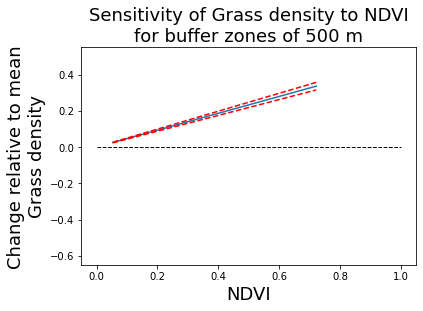

In [108]:
# plotting
for i, term in enumerate(uni_gam_500_7.terms):
    if term.isintercept:
        continue

    XX = uni_gam_500_7.generate_X_grid(term=i)
    pdep, confi = uni_gam_500_7.partial_dependence(term=i, X=XX, width=0.95)

    plt.figure()
    plt.plot(XX[:, term.feature], pdep)
    plt.hlines(y=0, xmin=0, xmax=1, linewidth=1, color='black', linestyle='--')
    plt.plot(XX[:, term.feature], confi, c='r', ls='--')
    ax = plt.gca()
    ax.set_ylim([-0.65, 0.55])
    # set title, xlabel and ylabel
    plt.title('Sensitivity of Grass density to NDVI\nfor buffer zones of 500 m', fontsize=18)
    plt.xlabel('NDVI', fontsize=18)
    plt.ylabel('Change relative to mean\nGrass density', fontsize=18)
    # save the figure
    plt.savefig('thesis_project/visualizations/modelling/univariate/gam_grass_500_best_plot_2.png', dpi=300, bbox_inches='tight')
    im.open('thesis_project/visualizations/modelling/univariate/gam_grass_500_best_plot_2.png').save('thesis_project/visualizations/modelling/univariate/gam_grass_500_best_plot_2.bmp')
    plt.show()

In [109]:
# Change in low NDVI values: how does grass% increase, if NDVI changes from 0.25 to 0.35?
grass_l0 = uni_gam_500_7.predict(0.25)
grass_l1 = uni_gam_500_7.predict(0.35)
grass_sens_low_500 = float(grass_l1 - grass_l0)
print('If NDVI goes from 0.25 to 0.35, grass%_500 increases by:', grass_sens_low_500)

If NDVI goes from 0.25 to 0.35, grass%_500 increases by: 0.04654250928086066


In [88]:
# Change in medium NDVI values: how does grass% increase, if NDVI changes from 0.45 to 0.55?
grass_m0 = uni_gam_500_7.predict(0.45)
grass_m1 = uni_gam_500_7.predict(0.55)
grass_sens_mid_500 = float(grass_m1 - grass_m0)
print('If NDVI goes from 0.45 to 0.55, grass%_500 increases by:', grass_sens_mid_500)

If NDVI goes from 0.45 to 0.55, grass%_500 increases by: 0.04654250928086068


In [89]:
# Change in high NDVI values: how does grass% increase, if NDVI changes from 0.65 to 0.75?
grass_h0 = uni_gam_500_7.predict(0.65)
grass_h1 = uni_gam_500_7.predict(0.75)
grass_sens_hig_500 = float(grass_h1 - grass_h0)
print('If NDVI goes from 0.65 to 0.75, grass%_500 increases by:', grass_sens_hig_500)

If NDVI goes from 0.65 to 0.75, grass%_500 increases by: 0.04654250928086062


## 4. Prediction sensitivity analysis

### 4.1. Sensitivity of vegetation types to increments in mean NDVI for a buffer zone of 100 m

In [155]:
# vegetation metrics sensitivity to changes in NDVI
data_100 = {'Increment in mean NDVI': ['Low-range (0.2 to 0.3)', 'Mid-range (0.4 to 0.5)', 'High-range (0.6 to 0.7)'], 
        'Greenspace%_100': [green_sens_low, green_sens_mid, green_sens_hig],
        'Canopy%_100': [canopy_sens_low, canopy_sens_mid, canopy_sens_hig], 
        'Shrubs%_100': [shrubs_sens_low, shrubs_sens_mid, shrubs_sens_hig],
        'Grass%_100': [grass_sens_low, grass_sens_mid, grass_sens_hig]}  
  
# create DataFrame  
df_sens_100 = pd.DataFrame(data_100)
df_sens_100 = df_sens_100.round(5)
df_sens_100.head()

,Increment in mean NDVI,Greenspace%_100,Canopy%_100,Shrubs%_100,Grass%_100
0,Low-range (0.2 to 0.3),0.17756,0.04974,0.09777,0.04838
1,Mid-range (0.4 to 0.5),0.15092,0.04375,0.09264,0.01775
2,High-range (0.6 to 0.7),0.06249,-0.03925,0.00420,0.12306


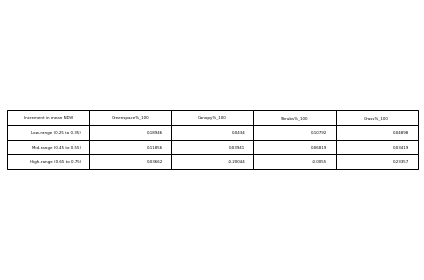

In [91]:
# plotting
fig, ax = plt.subplots()

# hide axes
fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')

ax.table(cellText=df_sens_100.values, colLabels=df_sens_100.columns, loc='center')

fig.tight_layout()

# save the figure
plt.savefig('thesis_project/visualizations/modelling/univariate/sensitivity_100_table_2.png', dpi=300, bbox_inches='tight')

plt.show()

### 4.2. Sensitivity of vegetation types to increments in mean NDVI for a buffer zone of 300 m

In [156]:
# vegetation metrics sensitivity to changes in NDVI
data_300 = {'Increment in mean NDVI': ['Low-range (0.2 to 0.3)', 'Mid-range (0.4 to 0.5)', 'High-range (0.6 to 0.7)'], 
        'Greenspace%_300': [green_sens_low_300, green_sens_mid_300, green_sens_hig_300],
        'Canopy%_300': [canopy_sens_low_300, canopy_sens_mid_300, canopy_sens_hig_300], 
        'Shrubs%_300': [shrubs_sens_low_300, shrubs_sens_mid_300, shrubs_sens_hig_300],
        'Grass%_300': [grass_sens_low_300, grass_sens_mid_300, grass_sens_hig_300]}  
  
# create DataFrame  
df_sens_300 = pd.DataFrame(data_300)
df_sens_300 = df_sens_300.round(4)
df_sens_300.head()

,Increment in mean NDVI,Greenspace%_300,Canopy%_300,Shrubs%_300,Grass%_300
0,Low-range (0.2 to 0.3),0.1671,0.0422,0.0849,0.0429
1,Mid-range (0.4 to 0.5),0.1477,0.0438,0.0556,0.0407
2,High-range (0.6 to 0.7),0.0746,-0.0471,0.0151,0.1078


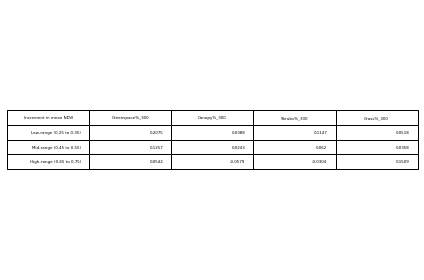

In [93]:
# plotting
fig, ax = plt.subplots()

# hide axes
fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')

ax.table(cellText=df_sens_300.values, colLabels=df_sens_300.columns, loc='center')

fig.tight_layout()

# save the figure
plt.savefig('thesis_project/visualizations/modelling/univariate/sensitivity_300_table_2.png', dpi=300, bbox_inches='tight')

plt.show()

### 4.3. Sensitivity of vegetation types to increments in mean NDVI for a buffer zone of 500 m

In [157]:
# vegetation metrics sensitivity to changes in NDVI
data_500 = {'Increment in mean NDVI': ['Low-range (0.2 to 0.3)', 'Mid-range (0.4 to 0.5)', 'High-range (0.6 to 0.7)'], 
        'Greenspace%_500': [green_sens_low_500, green_sens_mid_500, green_sens_hig_500],
        'Canopy%_500': [canopy_sens_low_500, canopy_sens_mid_500, canopy_sens_hig_500], 
        'Shrubs%_500': [shrubs_sens_low_500, shrubs_sens_mid_500, shrubs_sens_hig_500],
        'Grass%_500': [grass_sens_low_500, grass_sens_mid_500, grass_sens_hig_500]}  
  
# create DataFrame  
df_sens_500 = pd.DataFrame(data_500)
df_sens_500 = df_sens_500.round(4)
df_sens_500.head()

,Increment in mean NDVI,Greenspace%_500,Canopy%_500,Shrubs%_500,Grass%_500
0,Low-range (0.2 to 0.3),0.1406,0.0473,0.0503,0.0465
1,Mid-range (0.4 to 0.5),0.1380,0.0425,0.0265,0.0465
2,High-range (0.6 to 0.7),0.0816,-0.0111,-0.0026,0.0465


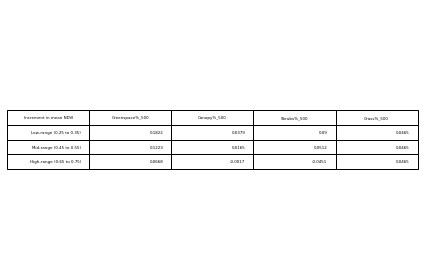

In [95]:
# plotting
fig, ax = plt.subplots()

# hide axes
fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')

ax.table(cellText=df_sens_500.values, colLabels=df_sens_500.columns, loc='center')

fig.tight_layout()

# save the figure
plt.savefig('thesis_project/visualizations/modelling/univariate/sensitivity_500_table_2.png', dpi=300, bbox_inches='tight')

plt.show()